In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import cartopy
import ac3airborne
from ac3airborne.tools import get_amsr2_seaice as seaice
import typhon as ty
import os
import src
from dotenv import load_dotenv

# use typhon ploting style
plt.style.use(ty.plots.styles.get('typhon'))

/net/secaire/mringel/.conda/envs/ac3env/lib/python3.10/site-packages/typhon/nonlte/rtc/__init__.py:9: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def FOSC(tau, Sb, Sm, Ib):


#### Load AC3 meta data

In [3]:
cat, meta, credentials, kwds = src.get_ac3_meta()

campaigns = ['ACLOUD','AFLUX','MOSAiC-ACA','HALO-AC3']

#### Calculate mean LWP over ERA5 domain and along P5 tracks, for every RF

In [87]:
ERA5_field_means = []
ERA5_field_stds = []
ERA5_track_means = []
ERA5_track_stds = []

P5_means = []

flight_id_labels = []

for campaign in campaigns:

    field_campaign_means = []
    field_campaign_stds = []
    track_campaign_means = []
    track_campaign_stds = []

    P5_campaign_means = []

    flight_id_labels_campaign = []

    for platform in ['P5']:
        for flight_id in list(cat[campaign][platform]['MiRAC-A']):

            flight = meta[campaign][platform][flight_id]

            takeoff = flight['takeoff']
            landing = flight['landing']

            ERA5_field = xr.open_dataset(f'/net/secaire/mringel/era5_alongFlights/tmp/field_{flight_id}_v4.nc')
            ERA5_track = xr.open_dataset(f'/net/secaire/mringel/era5_alongFlights/tmp/ERA5_{flight_id}_v3.nc')

            try: 
                P5_track = xr.open_dataset(f'/home/mringel/lwp_project/mringel/data/lwp_retrieved/{flight_id}_lwp_v3.nc')
                P5_campaign_means.append(P5_track.mean(dim='time').lwp*1000)
            except FileNotFoundError:
                P5_campaign_means.append(np.nan)

            # slice ERA5 data to flight time and only select sea ice free (var31) ocean (var172) cells
            ERA5_field = ERA5_field.sel(time=slice(takeoff,landing),drop=True)
            ERA5_field = ERA5_field.where((ERA5_field.var31==0.)&(ERA5_field.var172==0.),drop=True)

            try: 
                ERA5_field_avg = ERA5_field.mean(dim=['lon','lat','lat_2','time'],skipna=True)
                ERA5_field_std = ERA5_field.std(dim=['lon','lat','lat_2','time'],skipna=True)
            except:
                ERA5_field_avg = ERA5_field.mean(dim=['lon','lat','time'],skipna=True)
                ERA5_field_std = ERA5_field.std(dim=['lon','lat','time'],skipna=True)

            field_campaign_means.append(ERA5_field_avg.var78.values*1000)
            field_campaign_stds.append(ERA5_field_std.var78.values*1000)
            track_campaign_means.append(np.nanmean(ERA5_track.tclw.values)*1000)
            track_campaign_stds.append(np.nanstd(ERA5_track.tclw.values)*1000)
            
            flight_id_labels_campaign.append(flight_id.split("_")[-1])

            ERA5_field.close()
            ERA5_track.close()

    ERA5_field_means.append(field_campaign_means)
    ERA5_field_stds.append(field_campaign_stds)
    ERA5_track_means.append(track_campaign_means)
    ERA5_track_stds.append(track_campaign_stds)

    P5_means.append(P5_campaign_means)

    flight_id_labels.append(flight_id_labels_campaign)

deviations = [np.nanmean(np.array(ERA5_track_means[campaign_nr]) - np.array(ERA5_field_means[campaign_nr])) for campaign_nr in range(4)]

#### Plot results

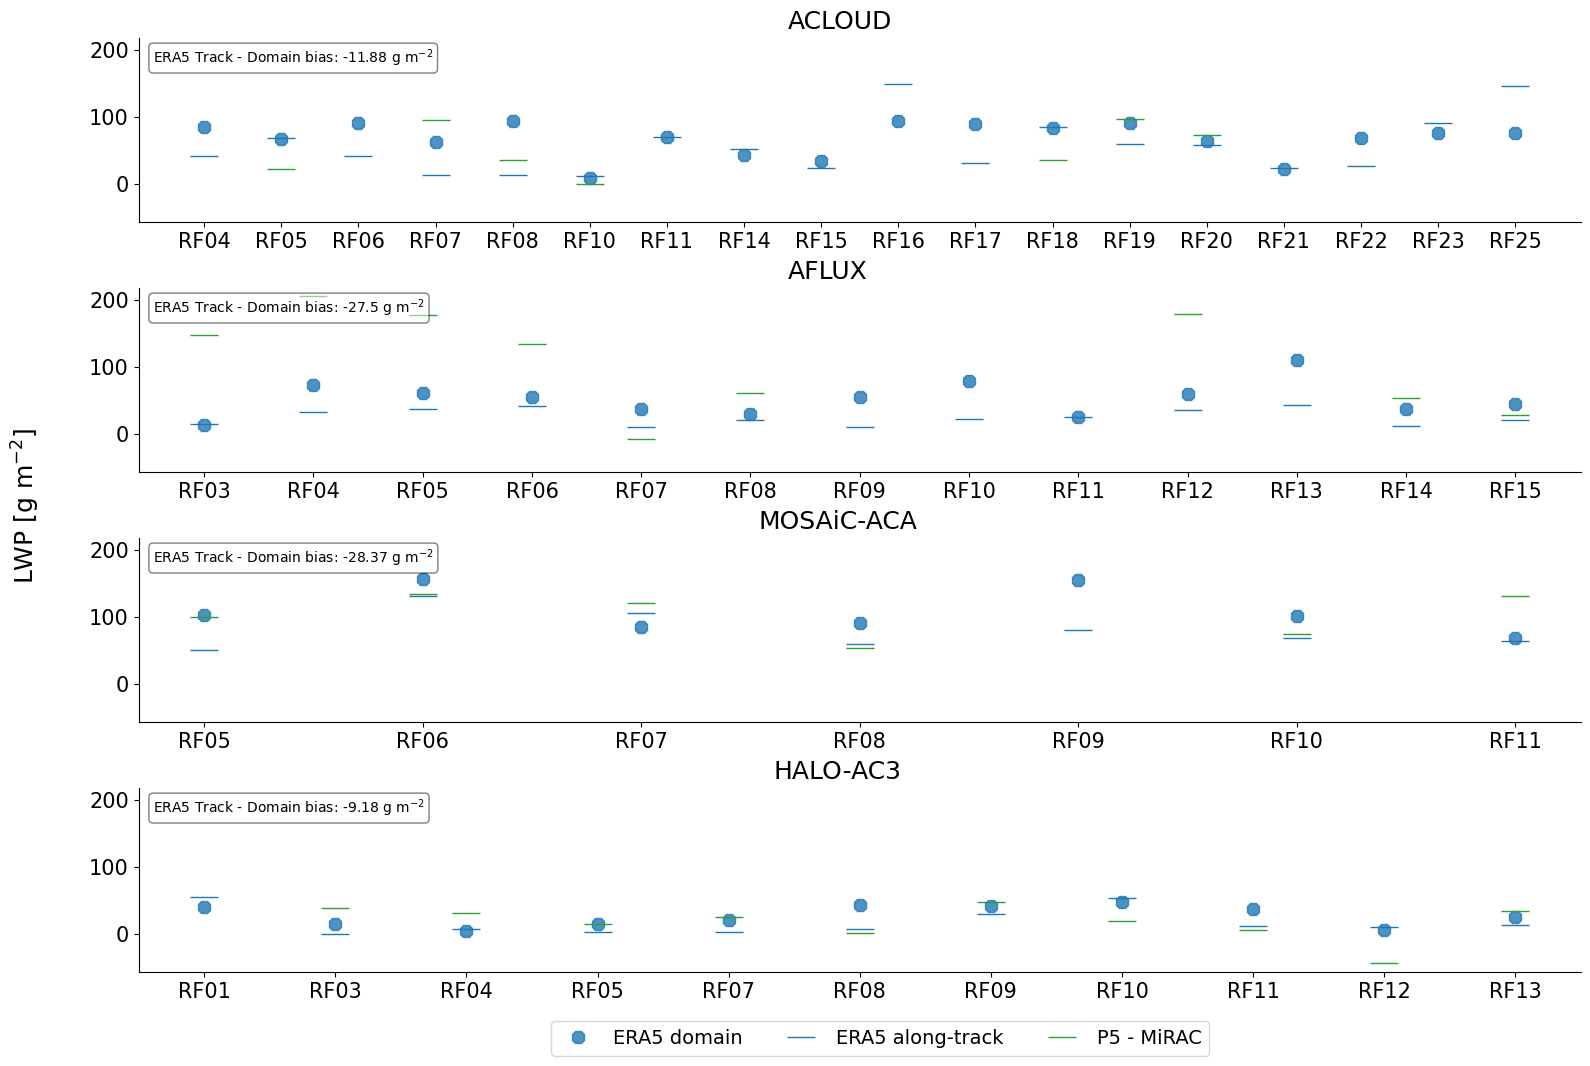

In [97]:
fig, axs = plt.subplots(ncols=1,nrows=4,figsize=(15,10),sharey=True)

for i,campaign in enumerate(campaigns):

    if i == 2:
        axs[i].text(0.43,1.05,campaign,transform=axs[i].transAxes)
    if i == 3:
        axs[i].text(0.44,1.05,campaign,transform=axs[i].transAxes)
    if i < 2:
        axs[i].text(0.45,1.05,campaign,transform=axs[i].transAxes)

    # plot ERA5 domain means
    axs[i].plot(flight_id_labels[i],ERA5_field_means[i],marker='8',linestyle='',color='C0',alpha=0.8,label='ERA5 domain')

    # plot ERA5 along-track means
    axs[i].plot(flight_id_labels[i],ERA5_track_means[i],marker='_',linestyle='',color='C0',markersize=20,label='ERA5 along-track')

    # plot P5 means
    axs[i].plot(flight_id_labels[i],P5_means[i],marker='_',linestyle='',color='C2',markersize=20,label='P5 - MiRAC')

    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    axs[i].text(0.01,0.95,"ERA5 Track - Domain bias: "+str(np.round(deviations[i],2))+" g m$^{-2}$",fontsize=10,transform=axs[i].transAxes,
                verticalalignment='top', bbox=props)

    handles, lgd_labels = axs[i].get_legend_handles_labels()
    
fig.text(-0.05, 0.5,'LWP [g m$^{-2}$]',rotation=90,fontsize=18,va='center')
#fig.text(0.48, -0.02,'Flight ID',fontsize=18,va='center')

fig.legend(handles, lgd_labels, 
           prop={'size': 14}, loc='lower center', ncols=3, bbox_to_anchor=(0.53,-0.06))

plt.savefig('/home/mringel/lwp_project/figures/ERA5_domain_vs_alongtrack_mean_LWP.png',
            bbox_inches='tight',
            dpi=200)

#### Plot domain area and P5 tracks

In [60]:
sic_avg_aflux = xr.open_dataset('/data/obs/campaigns/aflux/auxiliary/sea_ice/avg/AFLUX_mean_sic_asi-AMSR2-n6250-v5.4.nc')
sic_avg_acloud = xr.open_dataset('/data/obs/campaigns/acloud/auxiliary/sea_ice/avg/ACLOUD_mean_sic_asi-AMSR2-n6250-v5.4.nc')
sic_avg_mosaicaca = xr.open_dataset('/data/obs/campaigns/mosaic-aca/auxiliary/sea_ice/avg/MOSAiC-ACA_mean_sic_asi-AMSR2-n6250-v5.4.nc')
sic_avg_haloac3 = xr.open_dataset('/data/obs/campaigns/halo-ac3/auxiliary/sea_ice/avg/HALO-AC3_mean_sic_asi-AMSR2-n6250-v5.4.nc')

sic_datasets = [sic_avg_acloud,sic_avg_aflux,sic_avg_mosaicaca,sic_avg_haloac3]

sic_avg_all_campaigns = (sic_avg_acloud.sic + sic_avg_aflux.sic + sic_avg_mosaicaca.sic + sic_avg_haloac3.sic)/4

P5 = xr.open_dataset('/net/secaire/mringel/data/lwp_retrieved/all_campaigns_P5_lwp_v3.nc')
P5 = P5.dropna(dim='time')

/tmp/ipykernel_2638494/2175936566.py:58: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgd.legendHandles[1]._sizes = [18]


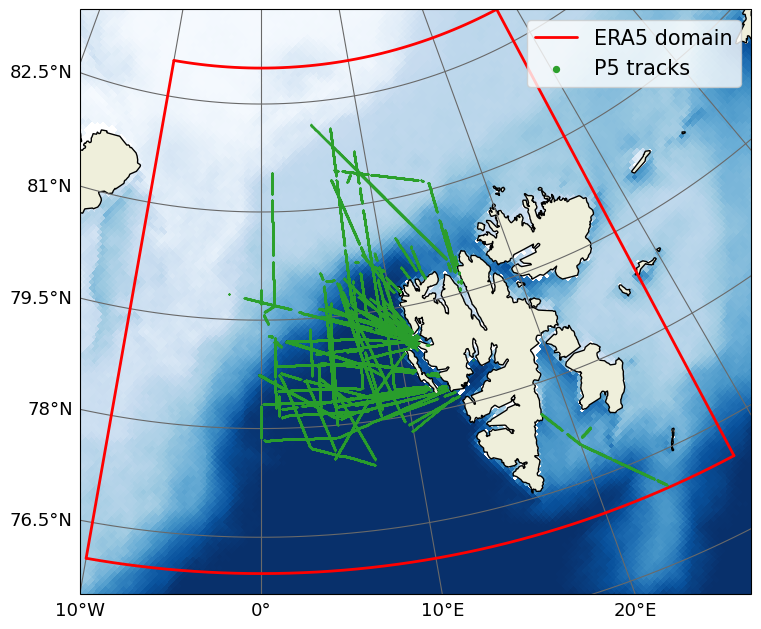

In [95]:
ax = plt.axes(projection=ccrs.NorthPolarStereo())

lon_min = -10.
lon_max = 28.
lat_min = 76.
lat_max = 83.

ax.set_extent([lon_min, lon_max, lat_min-0.5, lat_max], crs=ccrs.PlateCarree())

# plot sea-ice concentration
ax.pcolormesh(
    sic_avg_all_campaigns.lon,sic_avg_all_campaigns.lat,sic_avg_all_campaigns,
    cmap='Blues_r',
    transform=ccrs.PlateCarree())

# plot land
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')

# southern domain boundary
bnd_lons = np.linspace(lon_min,lon_max)
bnd_lats = np.full(len(bnd_lons),fill_value=lat_min)
plt.plot(bnd_lons,bnd_lats,transform=ccrs.PlateCarree(),linewidth=2,color='red')
# northern domain boundary
bnd_lons = np.linspace(lon_min,lon_max)
bnd_lats = np.full(len(bnd_lons),fill_value=lat_max)
plt.plot(bnd_lons,bnd_lats,transform=ccrs.PlateCarree(),linewidth=2,color='red')
# western domain boundary
bnd_lats = np.linspace(lat_min,lat_max)
bnd_lons = np.full(len(bnd_lats),fill_value=lon_min)
plt.plot(bnd_lons,bnd_lats,transform=ccrs.PlateCarree(),linewidth=2,color='red')
# eastern domain boundary
bnd_lats = np.linspace(lat_min,lat_max)
bnd_lons = np.full(len(bnd_lats),fill_value=lon_max)
plt.plot(bnd_lons,bnd_lats,transform=ccrs.PlateCarree(),linewidth=2,color='red',
         label='ERA5 domain'
        )

# gridlines
gl = ax.gridlines(color='dimgray',draw_labels=True,
                  x_inline=False, y_inline=False,
                  zorder=1,transform=ccrs.PlateCarree())
gl.rotate_labels = False
gl.right_labels = False 
gl.top_labels = False

ax.scatter(P5.lon,P5.lat,
           color='C2',
           label='P5 tracks',
           #alpha=0.15,
           s=0.05,
           zorder=2,
           transform=ccrs.PlateCarree())

gl.xlabel_style={'size': 13}
gl.ylabel_style={'size': 13}

lgd = ax.legend(loc='upper right')
lgd.legendHandles[1]._sizes = [18]

plt.savefig('/home/mringel/lwp_project/figures/ERA5_domain_vs_P5_tracks.png',
            bbox_inches='tight',
            dpi=200)